# Art Generation using Neural Style Transfer

This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

In [7]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import imageio

%matplotlib inline

## 1 - Problem Statement

Neural Style Transfer (NST) merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

 

## 2 - Transfer Learning

Loading pretrained VGG model 

In [3]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

## 3 - Neural Style Transfer 


### 3.1 - Computing the content cost



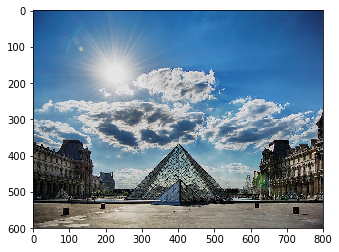

In [8]:
content_image = imageio.imread("images/louvre.jpg")
imshow(content_image)

In [9]:
def compute_content_cost(a_C, a_G):
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm=[0,3,1,2]), [m, n_C, -1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]), [m, n_C, -1])
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))/(4*n_H*n_W*n_C)
    
    return J_content

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655926


### 3.2 - Computing the style cost


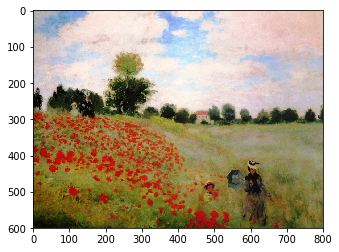

In [11]:
style_image = imageio.imread("images/monet_800600.jpg")
imshow(style_image)

### 3.2.1 Style Matrix

In [12]:
def gram_matrix(A):
    
    GA = tf.matmul(A, A, transpose_b=True)
    return GA

In [13]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


### 3.2.2 - Style cost

In [14]:
def compute_layer_style_cost(a_S, a_G):
       
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.reshape(tf.transpose(a_S, perm=[0,3,1,2]), [m, n_C, n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]), [m, n_C, n_H * n_W])

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = tf.reduce_sum(tf.squared_difference(GS, GG))/(4 * (n_C ** 2) * ((n_H*n_W)**2))
    
    
    return J_style_layer

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190277


### 3.2.3 Style Weights



In [16]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [17]:
def compute_style_cost(model, STYLE_LAYERS):
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name]  
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

In [18]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = (alpha * J_content) + (beta * J_style)
        
    return J

In [19]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## 4 - optimization 

In [20]:
# Reset the graph
tf.reset_default_graph()

# Starting interactive session
sess = tf.InteractiveSession()

Load, reshape, and normalize our "content" image:

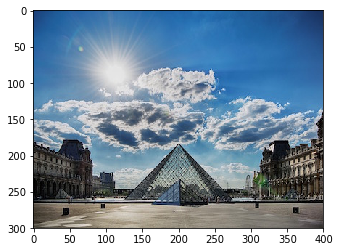

In [32]:
content_image = imageio.imread("images/louvre_small.jpg")
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)


Let's load, reshape and normalize our "style" image :

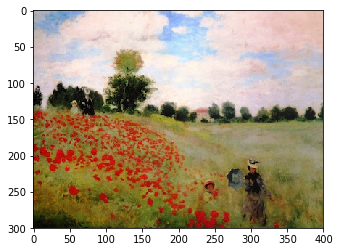

In [33]:
style_image = imageio.imread("images/monet.jpg")
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


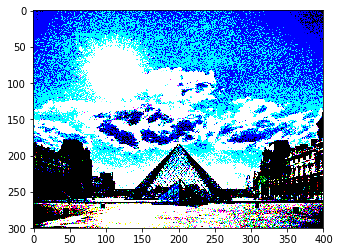

In [34]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [35]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [36]:
# content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [37]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

**Exercise**: Now that you have J_content and J_style, compute the total cost J by calling `total_cost()`. Use `alpha = 10` and `beta = 40`.

In [38]:
J = total_cost(J_content, J_style, alpha=10, beta=40)


Setup AdamOptimizer

In [39]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step 
train_step = optimizer.minimize(J)

In [40]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [41]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5061763000.0
content cost = 7854.4106
style cost = 126542120.0
Iteration 20 :
total cost = 942364200.0
content cost = 15056.627
style cost = 23555340.0
Iteration 40 :
total cost = 476313020.0
content cost = 16590.137
style cost = 11903678.0
Iteration 60 :
total cost = 307540830.0
content cost = 17287.63
style cost = 7684199.5
Iteration 80 :
total cost = 228170350.0
content cost = 17693.229
style cost = 5699835.5
Iteration 100 :
total cost = 182041730.0
content cost = 17973.963
style cost = 4546549.5
Iteration 120 :
total cost = 151659490.0
content cost = 18181.576
style cost = 3786942.0
Iteration 140 :
total cost = 129796340.0
content cost = 18335.865
style cost = 3240324.5
Iteration 160 :
total cost = 112983864.0
content cost = 18456.463
style cost = 2819982.5
Iteration 180 :
total cost = 99552090.0
content cost = 18569.438
style cost = 2484159.8


array([[[[ -41.626514 ,  -14.540655 ,   91.52786  ],
         [ -59.373306 ,  -12.77661  ,   57.791824 ],
         [ -32.02252  ,   -4.794298 ,   30.270344 ],
         ...,
         [ -13.5573   ,  -45.28029  ,   14.817284 ],
         [  -6.439783 ,  -42.06269  ,   27.471321 ],
         [ -15.147455 ,  -44.517403 ,   22.831612 ]],

        [[ -55.787987 ,  -13.015503 ,   51.09173  ],
         [ -35.967415 ,    4.3790717,   51.870937 ],
         [ -33.03736  ,    8.297527 ,   36.197227 ],
         ...,
         [  14.44726  ,  -71.21567  ,   10.770094 ],
         [   6.789032 ,  -74.883385 ,   24.239742 ],
         [   6.2599764, -108.707054 ,   38.195477 ]],

        [[ -27.758781 ,    7.7132063,   46.57717  ],
         [ -42.206394 ,    0.9328518,   36.942867 ],
         [ -46.973003 ,  -25.685644 ,   18.856615 ],
         ...,
         [  54.237732 ,  -56.141575 ,  -15.916387 ],
         [  15.446549 ,  -84.71107  ,   13.701974 ],
         [  13.113939 ,  -96.24823  ,   27.858923 ]],

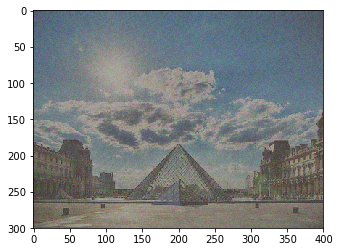

In [45]:
imshow(imageio.imread("./output/0.png"))

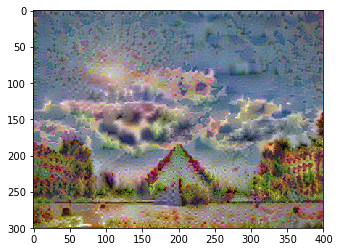

In [46]:
imshow(imageio.imread("./output/80.png"))

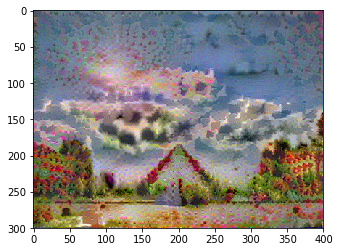

In [47]:
imshow(imageio.imread("./output/160.png"))